In [18]:
from numpy import *
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
from sklearn.cross_validation import cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix
sys.path.append("/Users/efandel/Desktop/iPython Tools")
from rtbpythonutils import *
%matplotlib inline

In [3]:
feature_columns = ['app_site_id','round(win_bid_dollars,1) as win_price','ad_type']

negative_ratio = 1.0

positives = redshift_compute('''
select case when conversions > 0 then 1 else 0 end as label,
  %s
from research_prod.bid_summary_4wk
where fiksu_app_id != '0'
  and used_target = 'cost_per_download'
  and conversions > 0
order by random()
limit 100000
'''%(', '.join(feature_columns)))

negatives = redshift_compute('''
select case when conversions > 0 then 1 else 0 end as label,
  %s
from research_prod.bid_summary_4wk
where fiksu_app_id != '0'
  and used_target = 'cost_per_download'
  and conversions = 0
  and impressions > 0
order by random()
limit %s
'''%(', '.join(feature_columns), int(len(positives)*negative_ratio)))
data = pd.concat([positives, negatives])

NameError: name 'pandas' is not defined

In [4]:
data = pd.concat([positives, negatives])

In [ ]:
data.to_csv('/Users/efandel/Desktop/GitHub/LogisticRegressionData')

In [8]:
data.app_site_id.nunique()

914

In [7]:
len(data)

65310

### How accurately can we predict whether an ad will convert or not based on win price?

In [29]:
x = data.win_price.values.reshape(-1,1)
y = data.label

In [13]:
%%time
scores = cross_val_score(LogisticRegression(), x, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))


CV AUC [ 0.74318312  0.74141052  0.74133114  0.73952387  0.73625725], Average AUC 0.740341181913
CPU times: user 446 ms, sys: 8.92 ms, total: 455 ms
Wall time: 477 ms


In [30]:
from sklearn import grid_search

Cs = np.arange(1, 100, 10)
gs = grid_search.GridSearchCV(
     estimator=LogisticRegression(),
     param_grid={'C': [50],
                },
     scoring='roc_auc',
     cv=5)

gs.fit(x, y)

print gs.best_score_ # mean squared error here comes in negative, so let's make it positive.
print gs.best_estimator_ # explains which grid_search setup worked best
print gs.grid_scores_ # shows all the grid pairings and their performances.

0.740341181913
LogisticRegression(C=50, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
[mean: 0.74034, std: 0.00235, params: {'C': 50}]


In [31]:
confusion_matrix(y,gs.predict(x))

array([[26426,  6229],
       [15485, 17170]])

In [32]:
gs.predict(x)

array([0, 1, 1, ..., 0, 0, 0])

In [33]:
pd.pivot_table(data,index='label',values='win_price',aggfunc = len)

label
0    32655.0
1    32655.0
Name: win_price, dtype: float64

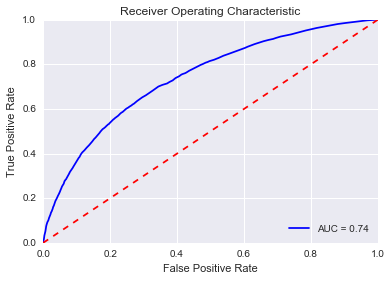

In [34]:
# calculate the fpr and tpr for all thresholds of the classification
probs = gs.predict_proba(x)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Let's see what happens when we include ad format & app ID as features as well

In [14]:
app_id = pd.get_dummies(data.app_site_id)
ad_type = pd.get_dummies(data.ad_type)


In [15]:
ad_type = pd.get_dummies(data.ad_type)
app_id = pd.get_dummies(data.app_site_id)

x = pd.concat([data['win_price'],ad_type,app_id],axis=1)

y = data.label

In [16]:
%%time
scores = cross_val_score(LogisticRegression(), x, y, scoring='roc_auc', cv=5)
print('CV AUC {}, Average AUC {}'.format(scores, scores.mean()))


CV AUC [ 0.77441406  0.77270602  0.7721133   0.76746047  0.76487588], Average AUC 0.770313945755
CPU times: user 5.13 s, sys: 2.46 s, total: 7.59 s
Wall time: 7.84 s


In [25]:
model = LogisticRegression()
model.fit(x,y)
confusion_matrix(y,model.predict(x))

array([[25047,  7608],
       [11556, 21099]])

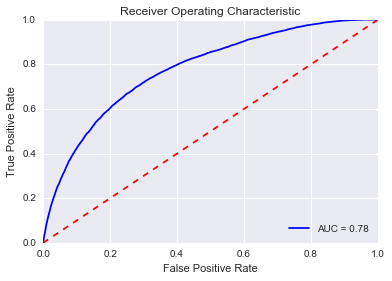

In [27]:
# calculate the fpr and tpr for all thresholds of the classification
probs = model.predict_proba(x)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y, preds)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Including the extra categorical features improved the AUC score from .74 to .78 